# Categorical DQN
- paper: https://arxiv.org/pdf/1707.06887.pdf
- good read: https://genrl.readthedocs.io/en/latest/usage/tutorials/Deep/Categorical_DQN.html

## Initialization, imports

In [179]:
NB_ID = '06'

import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import clear_output

from typing import Dict, List, Tuple

plt.ion()

## Replay buffer

In [180]:
class ReplayBuffer:
    # obs_size = state/observable space size
    def __init__(self, max_size: int, obs_size: int, batch_size:int=32):
        self.state_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        idx = self.ptr
        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample(self) -> Dict[str, np.ndarray]:
        idx = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
        )

    def __len__(self):
        return self.size

## Network

In [181]:
class Network(nn.Module):
    def __init__(
        self,
        in_size: int,
        out_size: int,
        # sefers to n. of atoms, not actual size of atom
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__()

        self.support = support
        self.out_dim = out_size
        self.atom_size = atom_size

        self.layers = nn.Sequential(
            nn.Linear(in_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_size * atom_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        q_atoms = self.layers(x).view(-1, self.out_dim, self.atom_size)
        # softmax between items of -1st dimension
        # softmax means normalize so that sum(dim) = 1
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)

        return dist

## Agent
`v_min` and `v_max` are new hyperparameters for which you should try to gauge what the highest and lowest total returns would be for some specific environment. 

For the cartpole environment, we know that 
- the minimum return is 0 (there are no negative rewards);
- the maximum is the n. of frames (because `reward = 1` for every frame, which is capped at 500)

Still not sure what's the procedure for selecting `atom_size`

In [182]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        eps_decay: float,
        max_eps: float = .9,
        min_eps: float = .1,
        gamma: float = .99,

        v_min: float = 0.0,
        v_max: float = 500.0,
        atom_n: int = 51,
    ):
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.eps_decay = eps_decay
        self.eps = max_eps
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.gamma = gamma

        # categorical DQN
        self.v_min = v_min
        self.v_max = v_max
        self.atom_n = atom_n
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_n, device=self.device
        )

        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        
        self.memory = ReplayBuffer(10000, obs_size, batch_size)
        
        self.dqn = Network(
            obs_size, action_size, atom_n, self.support
            ).to(self.device)
        self.dqn_target = Network(
            obs_size, action_size, atom_n, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # in the original tutorial, LR is not initialized.. but I think we're fine?
        # self.optimizer = optim.AdamW(self.dqn.parameters(), lr=self.lr, amsgrad=True)
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

        # FIXME: remove
        self.eff_episode = 0

    def choose_action(self, state: np.ndarray) -> int:
        explore = self.eps > np.random.random()
        if explore:
            selected_action = self.env.action_space.sample()
        if not explore or self.is_test:
            selected_action = self.dqn(torch.FloatTensor(state)).argmax().item()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.push(*self.transition)
            
        return next_state, reward, done
    
    def compute_dqn(self, samples: dict[str, np.array]):
        """calculate the DQN loss for a batch of memories"""
        device = self.device
        # each of these is a batch/samples of their corresponding name
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        # reshape(-1, 1) basically means 
        reward = torch.FloatTensor(samples["reward"], device=device).reshape(-1, 1)
        done = torch.FloatTensor(samples["done"], device=device).reshape(-1, 1)

        delta_z = float(self.v_max - self.v_min) / (self.atom_n - 1)

        with torch.no_grad():
            next_action = self.dqn_target(ns).argmax(-1)
            next_dist = self.dqn_target.dist(ns)
            # filter for the dists we want (eg. with largest sum)
            # we don't use gather here because pytorch would require idx tensor to have same shape as src, we ain't got time 4 that
            # next_dist = next_dist.gather(-1, next_action.unsqueeze(-1))
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1-done) * self.gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            # bounds for each atom
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            '''
            this is maybe the weirdest thing here. We do this instead of iterating through each batch item
            presumably because it performs better. but yeah this is just so we later iterate through collections of
            atoms. It has this format:
            [[0, 0, ...batch_size], [1*deltaZ, 1*deltaZ, ...batch_size], [2*deltaZ, 2*deltaZ, ...batch_size]]
            where deltaZ is the span between one atom to the other.
            hence, offset's shape is [atom_n, batch_size]

            you can see that l+offset and u+offset basically look like an arange of that shape
            '''
            offset = (torch.linspace(
                0, (self.batch_size - 1) * self.atom_n, self.batch_size, device=self.device
                ).long()
                # [[1], [2], [n]]]
                .unsqueeze(1)
                # [[1, 1, 1], [2, 2, 2], [n, n, n]] (for atom_n=3)
                .expand(-1, self.atom_n)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            # this is all to project our current probability dist. onto the atoms
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        # Wasserstein distance
        log_p = torch.log(dist[range(self.batch_size), action])

        loss = -(proj_dist * log_p).sum(1).mean()


        # # for debugging!
        # if self.eff_episode % 100 == 0:
            # print('state', state[:2])
            # print('ns', ns[:2])
            # print('act', action[:2])
            # print('rew', reward[:2])
            # print('done', done[:2])
            # print('curr_q', curr_q_value[:2])
            # print('next_q', next_q_value[:2])
            # print('target', target[:2])

        with torch.no_grad():
            returns = self.dqn(state)
            mean_return = returns.mean()

        return loss, mean_return.detach().numpy()
        
    def update_model(self) -> float:
        samples = self.memory.sample()

        loss, q_value = self.compute_dqn(samples)

        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item(), q_value

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            self.eff_episode = 0
            score = 0
            scores = []
            losses = []
            epsilons = []
            predictions = []
            
            for frame_idx in range(1, num_frames+1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                if done:
                    total_episodes += 1
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    self.eff_episode += 1
                    # linear decay
                    self.eps = max(self.min_eps, self.eps - (self.max_eps - self.min_eps) * self.eps_decay)
                    epsilons.append(self.eps)

                    if self.eff_episode % self.target_update == 0:
                        self.target_hard_update()

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{NB_ID}.s{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        # save current environment to swap it back later on
        naive_env = self.env
        
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, name_prefix=NB_ID)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons, predictions):

        clear_output(wait=True)
        # https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl
        # https://matplotlib.org/stable/_images/anatomy.png
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)

        ax1.set_title(f'frame {frame_idx} | score: {np.mean(scores[-10:])}')
        ax1.plot(scores)
        
        ax2.set_title('loss')
        ax2.plot(losses)

        ax3.set_title('Q value')
        ax3.plot(predictions)
        
        plt.show()


## Initializing environment

In [183]:
env_id = "CartPole-v1"
env = gym.make(env_id)

## Initializing environment

In [184]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initializing agent

In [185]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)

## Training
Note: I think we start with a high Q-value because the initial parameters and hence outputs are noisy, so there's a chance that there's a high probability weighting to atoms representing higher ranges of values, which is of course not accurate.

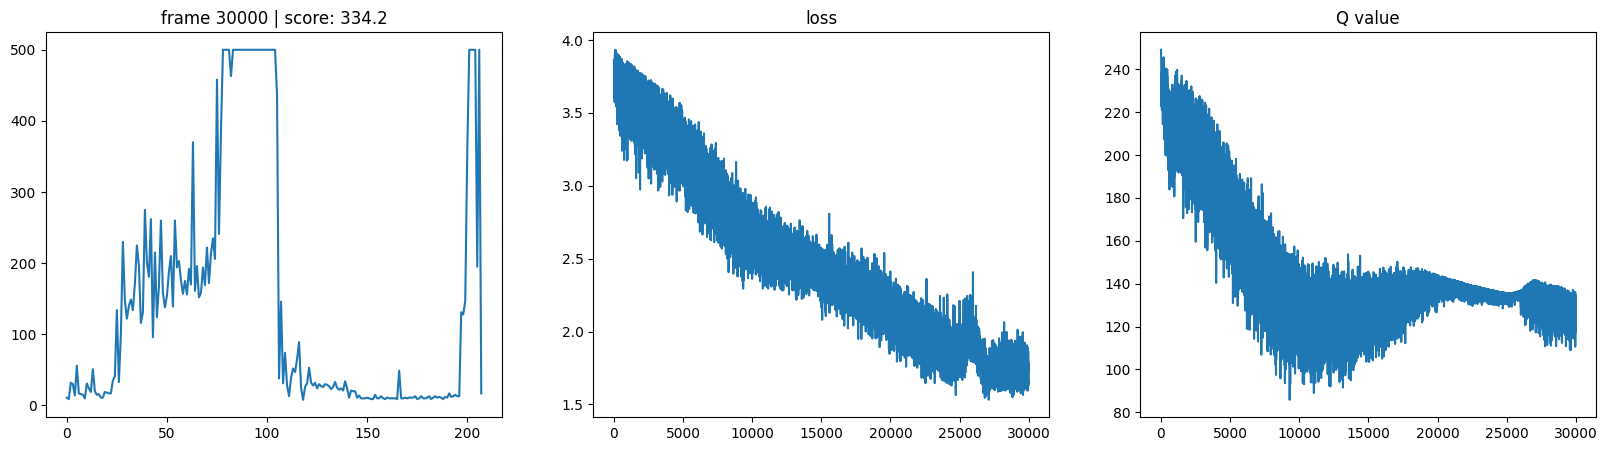

saved state!


In [186]:
agent.train(seed, num_frames)

## Training

In [187]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-state/{NB_ID}.s{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'saved-state/06.s111.pt'